# **PARALLEL CHESS ENGINE**

## **THÔNG TIN NHÓM**

| Họ và tên sinh viên |   MSSV   |
|---------------------|----------|
| Võ Văn Hiếu         | 19120511 |
| Huỳnh Đức Huy       | 19120526 |
| Vương Thế Khang     | 19120539 |

## **THƯ VIỆN**

In [5]:
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import matplotlib.pyplot as plt
import pandas as pd
import time

## **NHẮC LẠI**

#### **Phiên bản song song 1:** Song song hóa việc tính điểm cho các node con tại `search_depth = 0`

![Parallel v1 diagram](./images/parallel_v1_diagram.png "Parallel v1 diagram")

Phiên bản này có kernel đơn giản, dễ lập trình, nhưng chậm hơn phiên bản tuần tự, chỉ nhanh hơn khi không có cắt tỉa alpha-beta.

#### **Phiên bản song song 2:** Gọi minimax đệ quy đối với node con đầu tiên, các node con còn lại tính song song

![Parallel v2 diagram](./images/parallel_v2_diagram.png "Parallel v2 diagram")

Phiên bản này có tiến bộ hơn hẳn so với phiên bản tuần tự và phiên bản song song 1.


In [6]:
old_results_df = pd.read_csv('benchmark_results_p1.csv')
old_results_df

,Version,Score,Execution time,No. Evaluations
0,Sequential (basic),-1.2,353.63577,3107697
1,Sequential (alpha-beta),-1.2,2.11437,16293
2,Sequential (alpha-beta + move sorting),-1.2,1.39086,8579
3,Parallel v1 (basic),-1.2,106.02757,3107697
4,Parallel v1 (alpha-beta),-1.2,3.69681,107193
5,Parallel v1 (alpha-beta + move sorting),-1.2,3.46089,102329
6,Parallel v2 (basic),-1.2,2.15499,3107697
7,Parallel v2 (alpha-beta),-1.2,0.27087,19804
8,Parallel v2 (alpha-beta + move sorting),-1.2,0.28870,12138


## **THUẬT TOÁN TÌM KIẾM MINIMAX (TIẾP THEO)**

In [7]:
def handle_output(output, version_name, results_df = None):
    if results_df is None:
        results_df = pd.DataFrame()

    lines = output.stdout.split('\n')

    fen            = lines[0][lines[0].find(':') + 2:]
    execution_time = float(lines[1].split()[3])
    score          = float(lines[2].split()[2])
    n_evaluations  = int(lines[3].split()[3])
    encoded_move   = int(lines[4].split()[3])
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Version'         : [version_name],
        'Score'           : [score],
        'Execution time'  : [execution_time],
        'No. Evaluations' : [n_evaluations]
    }, index=[results_df.shape[0]])])
    
    game = ChessGame(fen)
    move = decode_move(encoded_move, game.side_to_move())
    game.plot(moves = [move])

    return results_df

### **PHIÊN BẢN SONG SONG 3**

#### Ý TƯỞNG

Ở phiên bản song song 2, hai giá trị `alpha` và `beta` được truyền vào như hai hằng số, tức là giá trị của chúng không được cập nhật mỗi khi một node con được tính toán xong.

Phiên bản song song 3 giống hệt phiên bản song song 2. Phiên bản này chỉ khác ở việc ta lưu hai giá trị `alpha` và `beta` trong GMEM và cập nhật chúng mỗi khi một node con hoàn thành việc tính toán.

Lúc này, ta cần một kỹ thuật để giúp ta định nghĩa một *critical section* trong hàm kernel. Kỹ thuật này là *mutual exclusion* hay *mutex*. Một mutex được biểu diễn là một số nguyên 32-bit trên GMEM. Lúc này, để khóa hoặc mở khóa mutex, ta dùng các toán tử atomic.

```python

@cuda.jit(device = True)
def possible_moves_device(board, castling_right, en_passant_target, halfmove, out_moves): # Find all possible moves,
    ...                                                                                   # return number of moves found

@cuda.jit(device = True)
def evaluate_board_device(board):  # Evaluate board
    ...

@cuda.jit(device = True)
def check_draw_device(board, castling_right, en_passant_target, halfmove): # Draw check
    ...

@cuda.jit(device = True)
def move_device(board, board2, castling_right, en_passant_target, halfmove, move): # Make a move,
    ...                                                                            # return updated game info

@cuda.jit(device = True)
def mutex_lock(mtx):
    while cuda.atomic.compare_and_swap(mutex, 0, 1) != 0:
        pass
    cuda.threadfence()

@cuda.jit(device = True)
def mutex_unlock(mtx):
    cuda.threadfence()
    cuda.atomic.exch(mutex, 0, 0)

@cuda.jit
def kernel_v3(boards, castling_rights, en_passant_targets, halfmoves, search_depth, alpha_beta, mutex):
    # Note: alpha_beta[0] is alpha, alpha_beta[1] is beta

    bid = cuda.blockIdx.x

    # Slice shared memory
    s_shared_i8  = cuda.shared.array(0, dtype = np.int8)
    s_shared_i32 = cuda.shared.array(0, dtype = np.int32)
    s_shared_f32 = cuda.shared.array(0, dtype = np.float32)

    s_boards             = s_shared_i8 [                        : 64 * (search_depth + 1)]
    s_castling_rights    = s_shared_i8 [64 * (search_depth + 1) : 65 * (search_depth + 1)]
    s_en_passant_targets = s_shared_i8 [65 * (search_depth + 1) : 66 * (search_depth + 1)]
    s_halfmoves          = s_shared_i8 [66 * (search_depth + 1) : 67 * (search_depth + 1)]
    s_status             = s_shared_i32[17 * (search_depth + 1) : 18 * (search_depth + 1)]
    s_alphas             = s_shared_f32[18 * (search_depth + 1) : 19 * (search_depth + 1)]
    s_betas              = s_shared_f32[19 * (search_depth + 1) : 20 * (search_depth + 1)]

    # A single 8-bit integer to tell all threads whether the kernel should exit or not base on alpha-beta
    s_should_break = cuda.shared.array(1, dtype = np.int8) 

    # Copy board and other info to shared memory
    if cuda.threadIdx.x < 64:
        s_boards[cuda.threadIdx.x] = boards[bid * 64 + cuda.threadIdx.x]
    if cuda.threadIdx.x == 0:
        s_castling_rights[0]    = castling_rights[bid]
        s_en_passant_targets[0] = en_passant_targets[bid]
        s_halfmoves[0]          = halfmoves[bid]

        mutex_lock(mutex)

        s_alphas[0] = -alpha_beta[1]
        s_betas[0]  = -alpha_beta[0]

        s_should_break[0] = 1 if alpha_beta[0] >= alpha_beta[1] else 0

        mutex_unlock(mutex)
    if cuda.threadIdx.x <= search_depth:
        s_status[cuda.threadIdx.x] = 0 if cuda.threadIdx.x == 0 else 1
    cuda.syncthreads()

    # Check for pruning condition
    if s_should_break[0] == 1:
        return

    # Allocate array to find moves
    out_moves = cuda.local.array(256, dtype = np.int32)

    if cuda.threadIdx.x <= search_depth:
        while True:
            while cuda.atomic.add(s_status, cuda.threadIdx.x, 0) == 1:  # Wait for job or exit
                continue
            if cuda.atomic.add(s_status, cuda.threadIdx.x, 0) > 1: # Exit
                break

            board             = s_boards[64 * cuda.threadIdx.x : 64 * (cuda.threadIdx.x + 1)]
            castling_right    = s_castling_rights[cuda.threadIdx.x]
            en_passant_target = s_en_passant_targets[cuda.threadIdx.x]
            halfmove          = s_halfmoves[cuda.threadIdx.x]

            if cuda.threadIdx.x == search_depth: # Leaf node
                s_alpha[cuda.threadIdx.x] = evaluate_board_device(board)
            else:
                # Find all moves, sort if needed
                n_moves = possible_moves_device(board, castling_right, en_passant_target, halfmove, out_moves)

                if n_moves == 0:
                    s_alphas[cuda.threadIdx.x] = 0.0 if check_draw_device(board, castling_right, en_passant_target, halfmove) else -inf
                else:
                    board2 = s_boards[64 * (cuda.threadIdx.x + 1) : 64 * (cuda.threadIdx.x + 2)]

                    for i in range(n_moves):

                        # Make move
                        move = out_moves[i]
                        castling_right2, en_passant_target2, halfmove2 = move_device(board, board2, 
                            castling_right, en_passant_target, halfmove, move)

                        # Send info to next thread
                        s_castling_rights[cuda.threadIdx.x + 1]    = castling_right2
                        s_en_passant_targets[cuda.threadIdx.x + 1] = en_passant_target2
                        s_halfmoves[cuda.threadIdx.x + 1]          = halfmove2
                        s_alphas[cuda.threadIdx.x + 1]             = -s_betas[cuda.threadIdx.x]
                        s_betas[cuda.threadIdx.x + 1]              = -s_alphas[cuda.threadIdx.x]

                        # Activate next thread
                        cuda.atomic.exch(s_status, cuda.threadIdx.x + 1, 0)

                        # Wait for next thread to finish
                        while cuda.atomic.add(s_status, cuda.threadIdx.x + 1, 0) == 0:
                            continue

                        if alpha_beta_prunning and -s_alphas[cuda.threadIdx.x + 1] >= s_betas[cuda.threadIdx.x]:
                            s_alphas[cuda.threadIdx.x] = s_betas[cuda.threadIdx.x]
                            break
                            
                        if -s_alphas[cuda.threadIdx.x + 1] > s_alphas[cuda.threadIdx.x]:
                            s_alphas[cuda.threadIdx.x] = -s_alphas[cuda.threadIdx.x + 1]

            # If the root thread finish, exit on all threads                
            if cuda.threadIdx.x == 0:
                mutex_lock(mutex)

                eval = -s_alphas[0]
                if eval > alpha_beta[0]:
                    alpha_beta[0] = eval

                mutex_unlock(mutex)

                for i in range(search_depth + 1):
                    cuda.atomic.exch(s_status, i, 2)

            # Else just update status
            else:
                cuda.atomic.exch(s_status, cuda.threadIdx.x, 1)

```

#### MINIMAX CƠ BẢN

In [8]:
%%writefile parallelv3_minimax_basic.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 9)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv3_minimax_basic.py


In [9]:
%%capture output
!python parallelv3_minimax_basic.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.08506,3107697


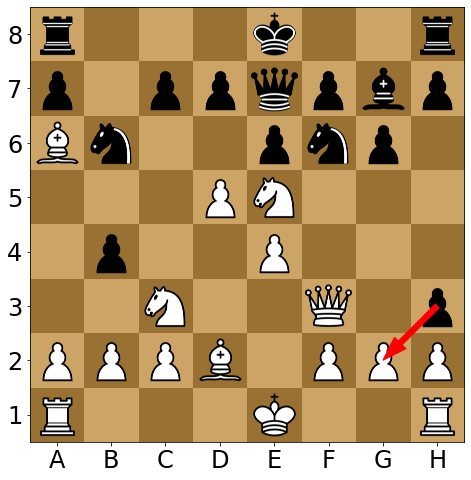

In [10]:
results_df = handle_output(output, 'Parallel v3 (basic)')
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

In [11]:
%%writefile parallelv3_minimax_alphabeta.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 10)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv3_minimax_alphabeta.py


In [12]:
%%capture output
!python parallelv3_minimax_alphabeta.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.08506,3107697
1,Parallel v3 (alpha-beta),-1.2,0.27150,19804


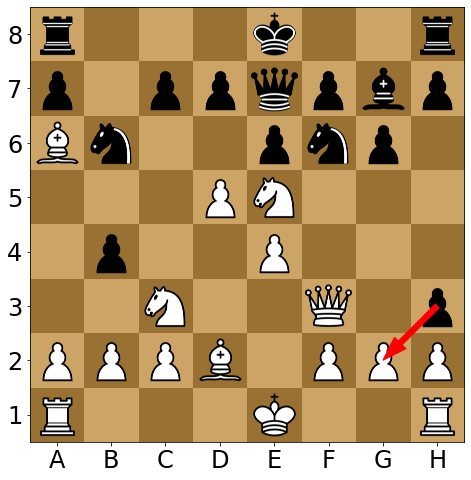

In [13]:
results_df = handle_output(output, 'Parallel v3 (alpha-beta)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

In [14]:
%%writefile parallelv3_minimax_alphabeta_movesorting.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 11)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv3_minimax_alphabeta_movesorting.py


In [15]:
%%capture output
!python parallelv3_minimax_alphabeta_movesorting.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.08506,3107697
1,Parallel v3 (alpha-beta),-1.2,0.27150,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.16638,12138


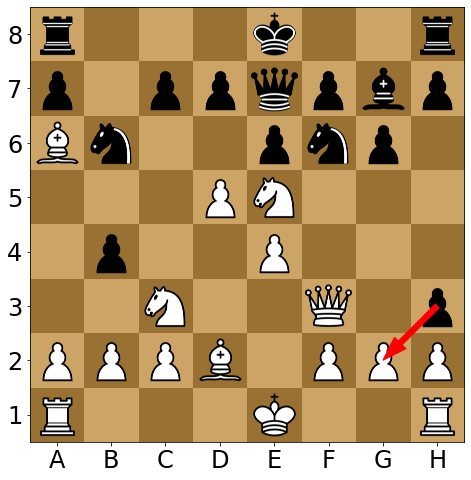

In [16]:
results_df = handle_output(output, 'Parallel v3 (alpha-beta + move sorting)', results_df)
results_df

### **PHIÊN BẢN SONG SONG 4**

#### Ý TƯỞNG

Tại một thế cờ bất kỳ, người chơi hiện tại sẽ có [trung bình khoảng 30 nước đi hợp lệ][1]. Hay nói cách khác, trong một cây trò chơi cờ vua, một node không phải là node lá sẽ có trung bình là 30 node con. Chính vì thế, các phiên bản song song 1, 2 và 3 phần lớn chỉ thực hiện tính điểm song song cho khoảng 30 thế cờ.

Nhóm muốn thử nghiệm hướng tiếp cận mới, chính là tính điểm song song cho nhiều node cùng lúc nhất có thể. Điều này cho ta có lý do để thực hiện chia stream khi tính toán song song. Hai phiên bản song song 4 và 5 được cài đặt theo hướng tếp cận này.

Phiên bản song song 4 gồm ba giai đoạn:
- Giai đoạn 1: Xuất phát từ node ban đầu, ta mở rộng cây trò chơi theo chiều rộng cho đến khi ta có số lượng node lá vượt một ngưỡng nào đó hoặc là đến khi đạt giới hạn tìm kiếm. Giai đoạn này thực hiện trên CPU. Khi mở rộng cây, ta lưu lại cấu trúc của cây.
- Giai đoạn 2: Tính điểm song song cho các node lá sử dụng kernel của phiên bản song song thứ 2. Giai đoạn này thực hiện trên GPU. Kết quả có được là một mảng các giá trị đánh giá của từng node lá.
- Giai đoạn 3: Dựa vào cấu trúc của cây đã ưu ở giai đoạn 1 và điểm số đã tính được ở giai đoạn 2, ta tìm giá trị đánh giá cuối cùng.

![Parallel v4 diagram](./images/parallel_v4_diagram.png "Parallel v4 diagram")

```python

def possible_moves(chess_game): # Move generation function
    ...

def parallel_v4_minimax(chess_game, search_depth):
    k = 256     # Threshold

    games = [chess_game]
    current_depth = search_depth

    while current_depth > 0 and len(games) < k:
        games_2 = []
        for game in games:
            moves = possible_moves(game)

            for move in moves:
                game_copy = game.copy()
                game_copy.move(move)
                games_2.append(game_copy)

        games = games_2
        current_depth -= 1

    # Continue just like parallel v2...

```

[1]: https://philippmuens.com/minimax-and-mcts#:~:text=On%20average%20there%20are%20~30%20moves%20a%20Chess%20player%20can%20play%20in%20any%20given%20game%20state.

#### MINIMAX CƠ BẢN

In [17]:
%%writefile parallelv4_minimax_basic.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 12)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv4_minimax_basic.py


In [18]:
%%capture output
!python parallelv4_minimax_basic.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.08506,3107697
1,Parallel v3 (alpha-beta),-1.2,0.27150,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.16638,12138
3,Parallel v4 (basic),-1.2,1.80142,3107697


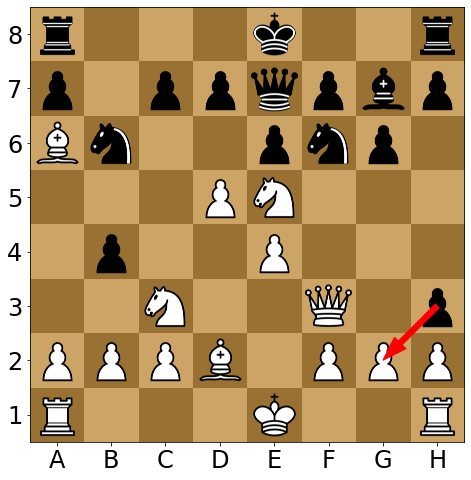

In [19]:
results_df = handle_output(output, 'Parallel v4 (basic)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

In [20]:
%%writefile parallelv4_minimax_alphabeta.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 13)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv4_minimax_alphabeta.py


In [21]:
%%capture output
!python parallelv4_minimax_alphabeta.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.08506,3107697
1,Parallel v3 (alpha-beta),-1.2,0.27150,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.16638,12138
3,Parallel v4 (basic),-1.2,1.80142,3107697
4,Parallel v4 (alpha-beta),-1.2,1.17332,754772


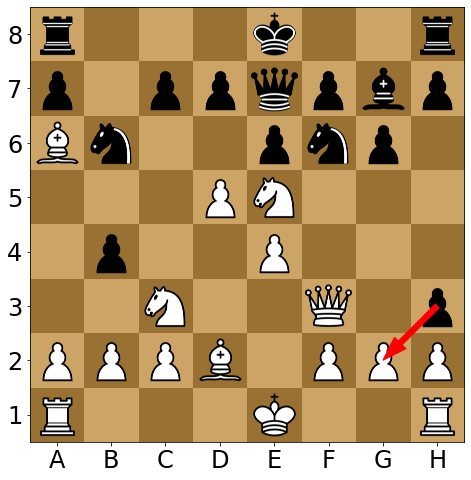

In [22]:
results_df = handle_output(output, 'Parallel v4 (alpha-beta)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

In [23]:
%%writefile parallelv4_minimax_alphabeta_movesorting.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 14)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv4_minimax_alphabeta_movesorting.py


In [24]:
%%capture output
!python parallelv4_minimax_alphabeta_movesorting.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.08506,3107697
1,Parallel v3 (alpha-beta),-1.2,0.27150,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.16638,12138
3,Parallel v4 (basic),-1.2,1.80142,3107697
4,Parallel v4 (alpha-beta),-1.2,1.17332,754772
5,Parallel v4 (alpha-beta + move sorting),-1.2,0.42432,232047


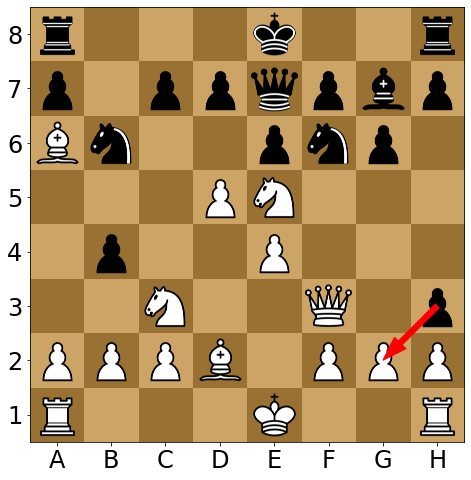

In [25]:
results_df = handle_output(output, 'Parallel v4 (alpha-beta + move sorting)', results_df)
results_df

### **PHIÊN BẢN SONG SONG 5**

#### Ý TƯỞNG

Phiên bản song song 5 cũng được cài đặt theo hướng tiếp cận trên. Tuy nhiên, phiên bản này khác phiên bản song song 4 ở cách mở rộng cây trò chơi. Phiên bản này sử dụng cách mở rộng cây trò chơi tương tự như phiên bản song song 2 và 3, tức là mở rộng theo chiều sâu ở node con đầu tiên.

![Parallel v5 diagram](./images/parallel_v5_diagram.png "Parallel v5 diagram")

Kernel của phiên bản này gần giống với kernel của phiên bản song song 3, với một số thay đổi:
- `search_depth` độc lập giữa các node.
- Các node có `search_depth = k` phải đợi đến khi tất cả các node có `search_depth < k` thực thi xong thì mới được bắt đầu. 

#### MINIMAX CƠ BẢN

In [26]:
%%writefile parallelv5_minimax_basic.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 15)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv5_minimax_basic.py


In [27]:
%%capture output
!python parallelv5_minimax_basic.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.08506,3107697
1,Parallel v3 (alpha-beta),-1.2,0.27150,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.16638,12138
3,Parallel v4 (basic),-1.2,1.80142,3107697
4,Parallel v4 (alpha-beta),-1.2,1.17332,754772
5,Parallel v4 (alpha-beta + move sorting),-1.2,0.42432,232047
6,Parallel v5 (basic),-1.2,2.43181,3107697


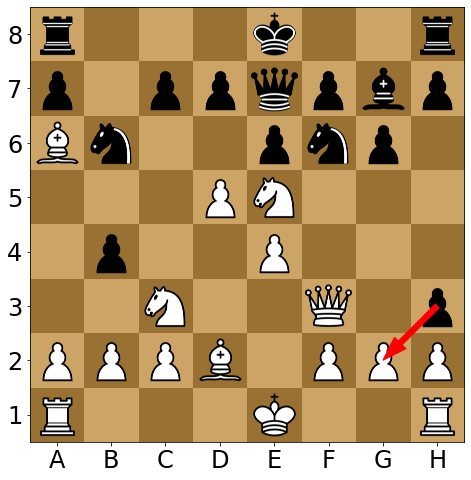

In [28]:
results_df = handle_output(output, 'Parallel v5 (basic)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

In [29]:
%%writefile parallelv5_minimax_alphabeta.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 16)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv5_minimax_alphabeta.py


In [30]:
%%capture output
!python parallelv5_minimax_alphabeta.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.08506,3107697
1,Parallel v3 (alpha-beta),-1.2,0.27150,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.16638,12138
3,Parallel v4 (basic),-1.2,1.80142,3107697
4,Parallel v4 (alpha-beta),-1.2,1.17332,754772
5,Parallel v4 (alpha-beta + move sorting),-1.2,0.42432,232047
6,Parallel v5 (basic),-1.2,2.43181,3107697
7,Parallel v5 (alpha-beta),-1.2,0.23977,18803


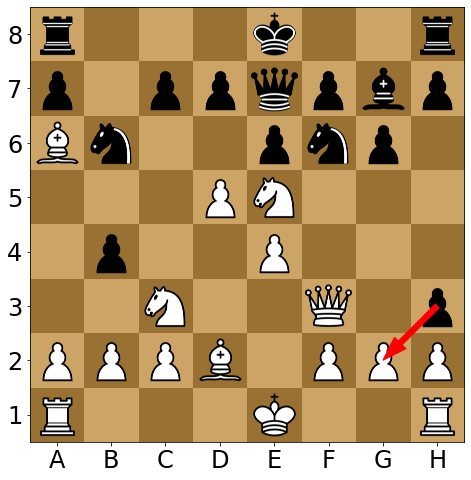

In [31]:
results_df = handle_output(output, 'Parallel v5 (alpha-beta)', results_df)
results_df

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

In [32]:
%%writefile parallelv5_minimax_alphabeta_movesorting.py
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
from numba import cuda
import pandas as pd
import time
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--fen')
parser.add_argument('--search_depth')

args = parser.parse_args()
if args.search_depth is None:
    args.search_depth = 1
else:
    args.search_depth = int(args.search_depth)

game = ChessGame(args.fen)

cuda.profile_start()
start = time.time()
move, score = find_move(game, args.search_depth, version = 17)
end = time.time()
cuda.profile_stop()

fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' if args.fen is None else args.fen

print(f'FEN             : {fen}')
print(f'Execution time  : {round(end - start, 5)} s')
print(f'Score           : {round(score, 3)}')
print(f'No. Evaluations : {get_evaluation_count()}')
print(f'Encoded move    : {encode_move(move)}')

Overwriting parallelv5_minimax_alphabeta_movesorting.py


In [33]:
%%capture output
!python parallelv5_minimax_alphabeta_movesorting.py --fen="r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1" --search_depth=4

,Version,Score,Execution time,No. Evaluations
0,Parallel v3 (basic),-1.2,2.08506,3107697
1,Parallel v3 (alpha-beta),-1.2,0.27150,19804
2,Parallel v3 (alpha-beta + move sorting),-1.2,0.16638,12138
3,Parallel v4 (basic),-1.2,1.80142,3107697
4,Parallel v4 (alpha-beta),-1.2,1.17332,754772
5,Parallel v4 (alpha-beta + move sorting),-1.2,0.42432,232047
6,Parallel v5 (basic),-1.2,2.43181,3107697
7,Parallel v5 (alpha-beta),-1.2,0.23977,18803
8,Parallel v5 (alpha-beta + move sorting),-1.2,0.05515,10165


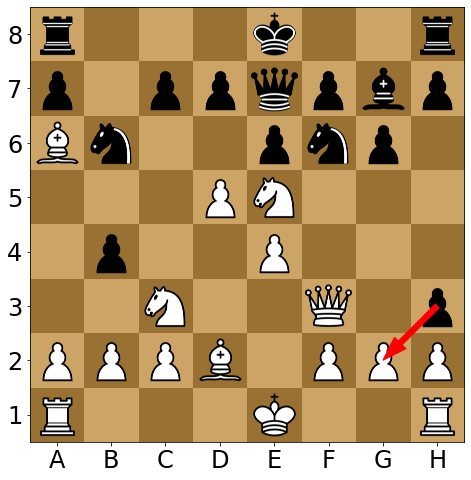

In [34]:
results_df = handle_output(output, 'Parallel v5 (alpha-beta + move sorting)', results_df)
results_df

In [35]:
results_df.to_csv('benchmark_results_p2.csv', index = False)

## **NHẬN XÉT**

### **HIỆU SUẤT CẮT TỈA**

In [36]:
results_df = pd.concat([old_results_df, results_df], ignore_index = True)
results_df

,Version,Score,Execution time,No. Evaluations
0,Sequential (basic),-1.2,353.63577,3107697
1,Sequential (alpha-beta),-1.2,2.11437,16293
2,Sequential (alpha-beta + move sorting),-1.2,1.39086,8579
3,Parallel v1 (basic),-1.2,106.02757,3107697
4,Parallel v1 (alpha-beta),-1.2,3.69681,107193
5,Parallel v1 (alpha-beta + move sorting),-1.2,3.46089,102329
6,Parallel v2 (basic),-1.2,2.15499,3107697
7,Parallel v2 (alpha-beta),-1.2,0.27087,19804
8,Parallel v2 (alpha-beta + move sorting),-1.2,0.28870,12138
9,Parallel v3 (basic),-1.2,2.08506,3107697


In [68]:
results_df['Major version'] = results_df['Version'] \
    .str.removesuffix(' (basic)') \
    .str.removesuffix(' (alpha-beta)') \
    .str.removesuffix(' (alpha-beta + move sorting)')

results_df['Minor version'] = results_df['Version'] \
    .str.removeprefix('Sequential ') \
    .str.removeprefix('Parallel v') \
    .str.removeprefix('1 ') \
    .str.removeprefix('2 ') \
    .str.removeprefix('3 ') \
    .str.removeprefix('4 ') \
    .str.removeprefix('5 ') \
    .str.strip('()')

results_df

,Version,Score,Execution time,No. Evaluations,Major version,Minor version
0,Sequential (basic),-1.2,353.63577,3107697,Sequential,basic
1,Sequential (alpha-beta),-1.2,2.11437,16293,Sequential,alpha-beta
2,Sequential (alpha-beta + move sorting),-1.2,1.39086,8579,Sequential,alpha-beta + move sorting
3,Parallel v1 (basic),-1.2,106.02757,3107697,Parallel v1,basic
4,Parallel v1 (alpha-beta),-1.2,3.69681,107193,Parallel v1,alpha-beta
5,Parallel v1 (alpha-beta + move sorting),-1.2,3.46089,102329,Parallel v1,alpha-beta + move sorting
6,Parallel v2 (basic),-1.2,2.15499,3107697,Parallel v2,basic
7,Parallel v2 (alpha-beta),-1.2,0.27087,19804,Parallel v2,alpha-beta
8,Parallel v2 (alpha-beta + move sorting),-1.2,0.28870,12138,Parallel v2,alpha-beta + move sorting
9,Parallel v3 (basic),-1.2,2.08506,3107697,Parallel v3,basic


In [125]:
major_versions = [
    'Sequential',
    'Parallel v1',
    'Parallel v2',
    'Parallel v3',
    'Parallel v4',
    'Parallel v5'
]

minor_versions = [
    'basic',
    'alpha-beta',
    'alpha-beta + move sorting'
]

final_results_df = pd.DataFrame()

final_results_df['Version'] = major_versions
final_results_df.set_index('Version')

for minor_version in minor_versions:
    final_results_df[f'Execution time ({minor_version})'] = results_df[results_df['Minor version'] == minor_version]['Execution time'].to_list()
    final_results_df[f'No. Evaluations ({minor_version})'] = results_df[results_df['Minor version'] == minor_version]['No. Evaluations'].to_list()

final_results_df

,Version,Execution time (basic),No. Evaluations (basic),Execution time (alpha-beta),No. Evaluations (alpha-beta),Execution time (alpha-beta + move sorting),No. Evaluations (alpha-beta + move sorting)
0,Sequential,353.63577,3107697,2.11437,16293,1.39086,8579
1,Parallel v1,106.02757,3107697,3.69681,107193,3.46089,102329
2,Parallel v2,2.15499,3107697,0.27087,19804,0.28870,12138
3,Parallel v3,2.08506,3107697,0.27150,19804,0.16638,12138
4,Parallel v4,1.80142,3107697,1.17332,754772,0.42432,232047
5,Parallel v5,2.43181,3107697,0.23977,18803,0.05515,10165


In [126]:
def bar_plot(x, y):
    _, ax = plt.subplots(figsize=(12, 8))
    colors = ['g' if (bar == max(y)) else 'r' if (bar == min(y)) else 'b' for bar in y]
    ax.bar(x, y, color = colors)

Với mỗi phiên bản, ta tính **hiệu suất cắt tỉa khi không có sắp xếp node con**, chính là *tỉ lệ node được bỏ qua do cắt tỉa alpha-beta*.

,Version,Execution time (basic),No. Evaluations (basic),Execution time (alpha-beta),No. Evaluations (alpha-beta),Execution time (alpha-beta + move sorting),No. Evaluations (alpha-beta + move sorting),Pruning efficiency without sorting
0,Sequential,353.63577,3107697,2.11437,16293,1.39086,8579,0.994757
1,Parallel v1,106.02757,3107697,3.69681,107193,3.46089,102329,0.965507
2,Parallel v2,2.15499,3107697,0.27087,19804,0.28870,12138,0.993627
3,Parallel v3,2.08506,3107697,0.27150,19804,0.16638,12138,0.993627
4,Parallel v4,1.80142,3107697,1.17332,754772,0.42432,232047,0.757128
5,Parallel v5,2.43181,3107697,0.23977,18803,0.05515,10165,0.993950


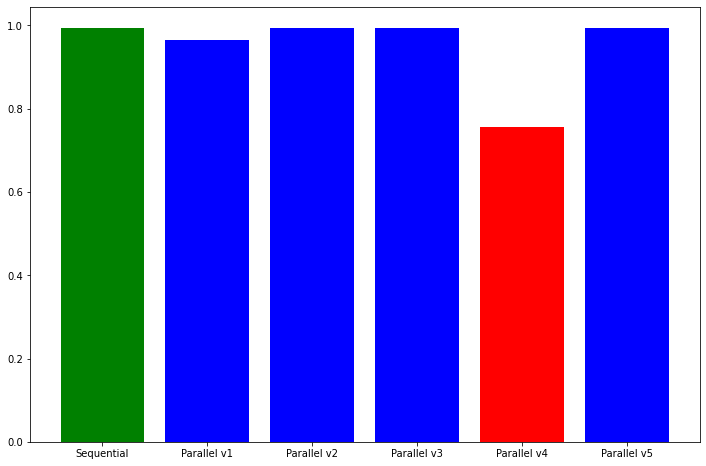

In [127]:
final_results_df['Pruning efficiency without sorting'] = 1.0 - final_results_df['No. Evaluations (alpha-beta)'] / final_results_df['No. Evaluations (basic)']
bar_plot(final_results_df['Version'], final_results_df['Pruning efficiency without sorting'])
final_results_df

**Nhận xét**:
- Phiên bản tuần tự có hiệu suất cắt tỉa khi không có sắp xếp node con cao nhất. Tuy nhiên các phiên bản song song 1, 2, 3 và 5 cũng có hiệu suất cắt tỉa cao gần bằng với phiên bản tuần tự.
- Phiên bản song song 4 có hiệu suất cắt tỉa khi không có sắp xếp node con thấp nhất.

Với mỗi phiên bản, ta tính **hiệu suất cắt tỉa khi sắp xếp node con**, chính là *tỉ lệ node được bỏ qua do cắt tỉa alpha-beta và sắp xếp node con*.

,Version,Execution time (basic),No. Evaluations (basic),Execution time (alpha-beta),No. Evaluations (alpha-beta),Execution time (alpha-beta + move sorting),No. Evaluations (alpha-beta + move sorting),Pruning efficiency without sorting,Pruning efficiency with sorting
0,Sequential,353.63577,3107697,2.11437,16293,1.39086,8579,0.994757,0.997239
1,Parallel v1,106.02757,3107697,3.69681,107193,3.46089,102329,0.965507,0.967072
2,Parallel v2,2.15499,3107697,0.27087,19804,0.28870,12138,0.993627,0.996094
3,Parallel v3,2.08506,3107697,0.27150,19804,0.16638,12138,0.993627,0.996094
4,Parallel v4,1.80142,3107697,1.17332,754772,0.42432,232047,0.757128,0.925332
5,Parallel v5,2.43181,3107697,0.23977,18803,0.05515,10165,0.993950,0.996729


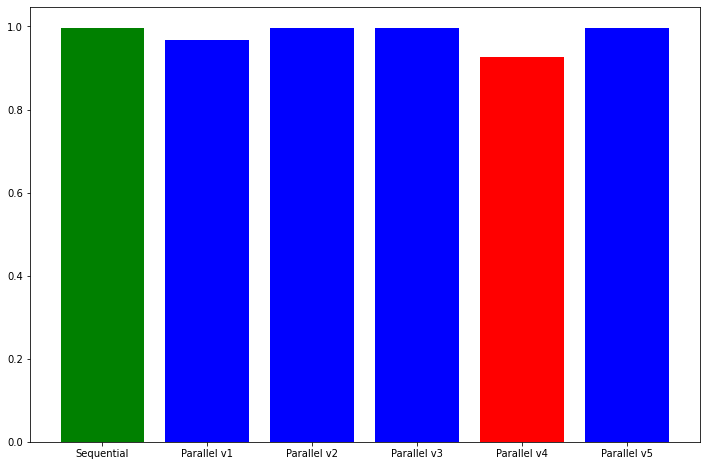

In [128]:
final_results_df['Pruning efficiency with sorting'] = 1.0 - final_results_df['No. Evaluations (alpha-beta + move sorting)'] / final_results_df['No. Evaluations (basic)']
bar_plot(final_results_df['Version'], final_results_df['Pruning efficiency with sorting'])
final_results_df

**Nhận xét**:
- Phiên bản tuần tự có hiệu suất cắt tỉa khi sắp xếp node con cao nhất. Tuy nhiên các phiên bản song song 1, 2, 3 và 5 cũng có hiệu suất cắt tỉa cao gần bằng với phiên bản tuần tự.
- Phiên bản song song 4 có hiệu suất cắt tỉa khi sắp xếp node con thấp nhất. Tuy nhiên, do có sắp xếp node con, hiệu suất cắt tỉa cao hơn hẳn so với khi không có sắp xếp node con.

Với mỗi phiên bản, ta tính **hệ số ảnh hưởng của việc sắp xếp node con**, chính là *tỉ lệ node duyệt qua giảm đi khi cắt tỉa do ảnh hưởng của việc sắp xếp node con*.

,Version,Execution time (basic),No. Evaluations (basic),Execution time (alpha-beta),No. Evaluations (alpha-beta),Execution time (alpha-beta + move sorting),No. Evaluations (alpha-beta + move sorting),Pruning efficiency without sorting,Pruning efficiency with sorting,Sorting impact
0,Sequential,353.63577,3107697,2.11437,16293,1.39086,8579,0.994757,0.997239,0.473455
1,Parallel v1,106.02757,3107697,3.69681,107193,3.46089,102329,0.965507,0.967072,0.045376
2,Parallel v2,2.15499,3107697,0.27087,19804,0.28870,12138,0.993627,0.996094,0.387094
3,Parallel v3,2.08506,3107697,0.27150,19804,0.16638,12138,0.993627,0.996094,0.387094
4,Parallel v4,1.80142,3107697,1.17332,754772,0.42432,232047,0.757128,0.925332,0.692560
5,Parallel v5,2.43181,3107697,0.23977,18803,0.05515,10165,0.993950,0.996729,0.459395


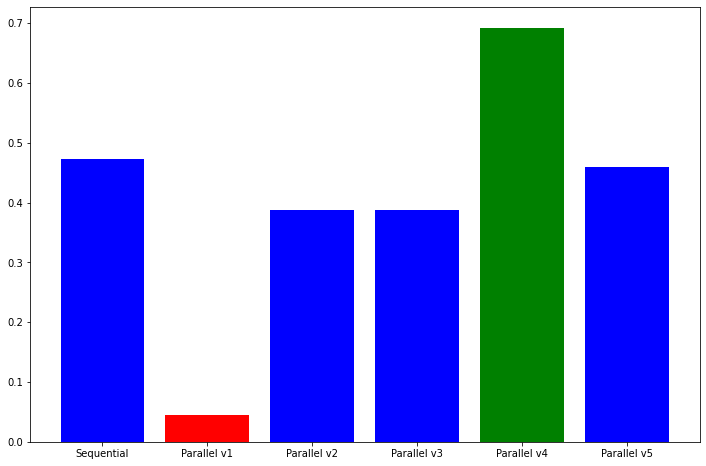

In [129]:
final_results_df['Sorting impact'] = 1.0 - final_results_df['No. Evaluations (alpha-beta + move sorting)'] / final_results_df['No. Evaluations (alpha-beta)']
bar_plot(final_results_df['Version'], final_results_df['Sorting impact'])
final_results_df

**Nhận xét**:
- Đối với phiên bản tuần tự, phiên bản song song 2, 3 và 5, việc sắp xếp node con có ảnh hưởng trung bình.
- Đối với phiên bản song song 4, việc sắp xếp node con có ảnh hưởng cao.
- Đối với phiên bản song song 1, việc sắp xếp node con có ảnh hưởng thấp.

### **THỜI GIAN THỰC THI**

In [130]:
benchmark_results_df = pd.read_csv('benchmark_results_multidepth.csv')
benchmark_results_df

,Version,Version name,Search depth,Score,Execution time,No. Evaluations
0,0,Sequential,2,-2.70,0.21664,1781
1,0,Sequential,3,0.65,6.96226,61320
2,0,Sequential,4,-1.20,361.66696,3107697
3,1,Sequential + Alpha-beta,2,-2.70,0.04186,309
4,1,Sequential + Alpha-beta,3,0.65,0.40939,3212
...,...,...,...,...,...,...
84,17,Parallel v5 + Alpha-beta + Move sorting,3,0.65,0.07167,2937
85,17,Parallel v5 + Alpha-beta + Move sorting,4,-1.20,0.16992,10165
86,17,Parallel v5 + Alpha-beta + Move sorting,5,2.15,0.55403,92974
87,17,Parallel v5 + Alpha-beta + Move sorting,6,-1.00,2.42448,601707


In [141]:
version_names_df = benchmark_results_df[['Version', 'Version name']].drop_duplicates(keep = 'first').set_index('Version')
version_names_df

,Version name
Version,
0,Sequential
1,Sequential + Alpha-beta
2,Sequential + Alpha-beta + Move sorting
3,Parallel v1
4,Parallel v1 + Alpha-beta
5,Parallel v1 + Alpha-beta + Move sorting
6,Parallel v2
7,Parallel v2 + Alpha-beta
8,Parallel v2 + Alpha-beta + Move sorting


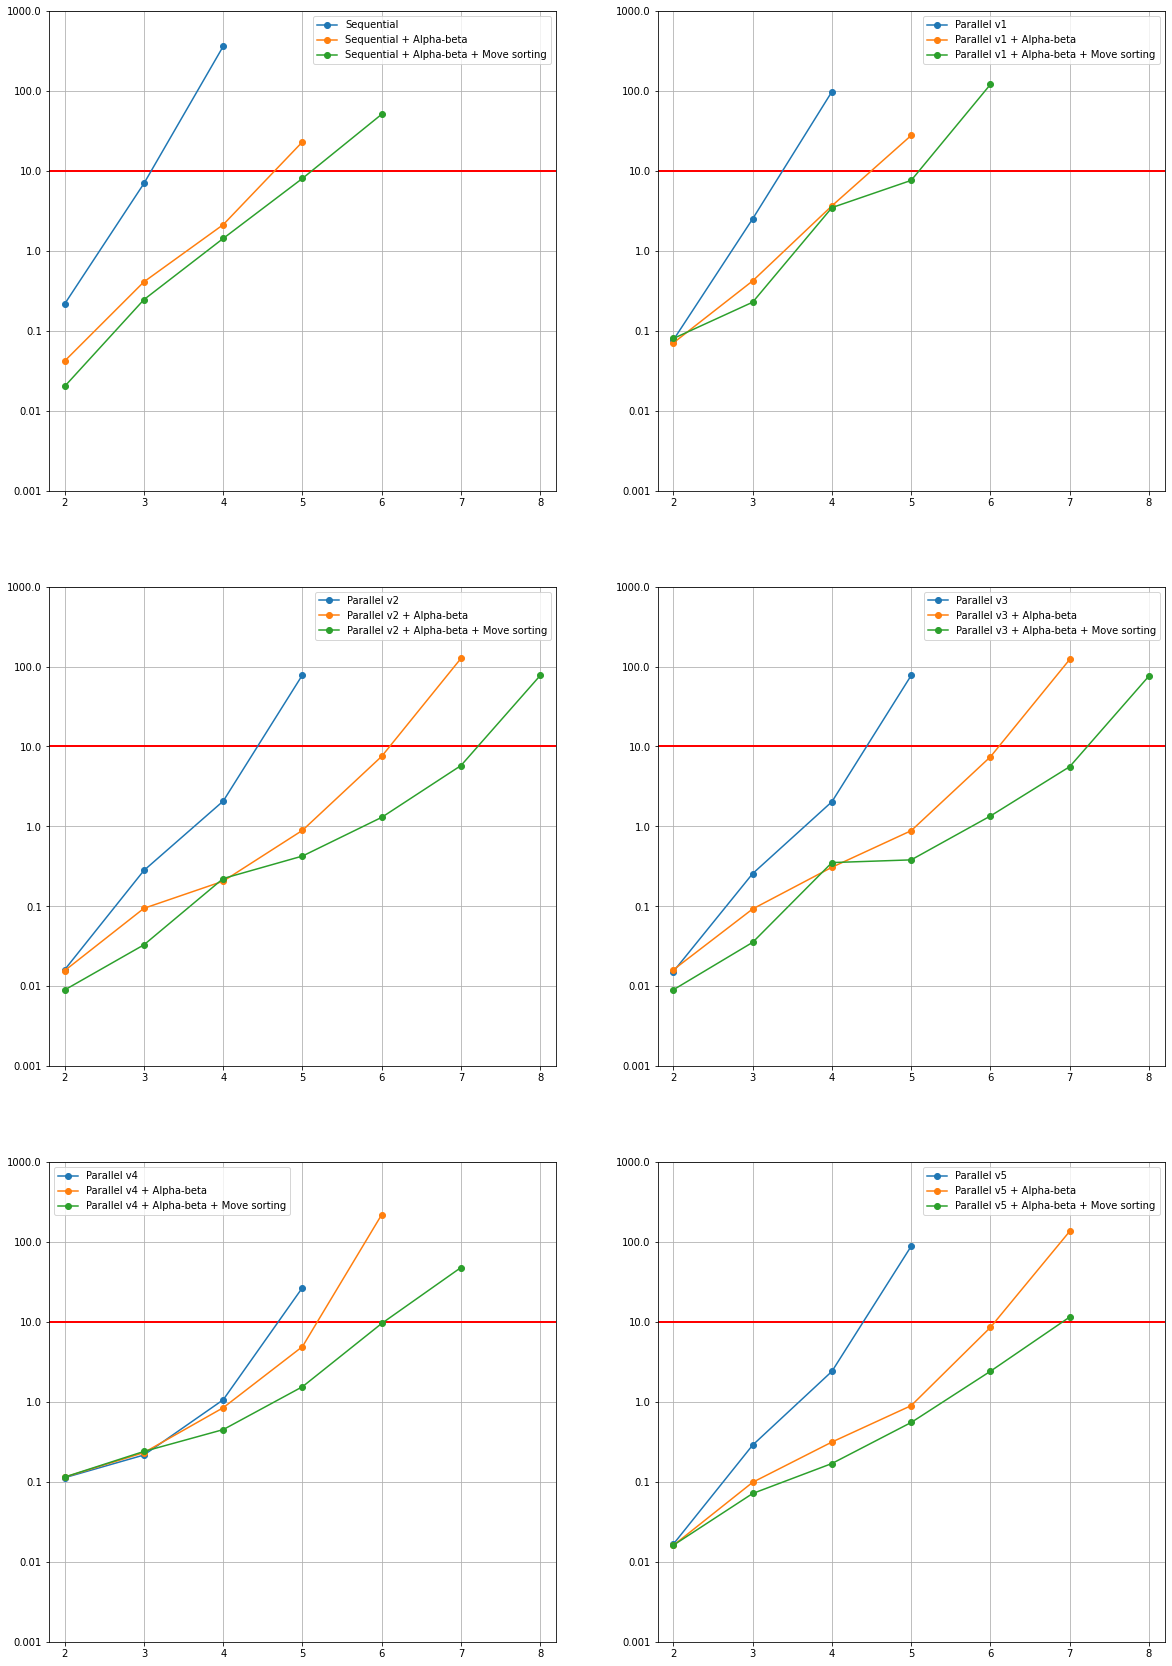

In [188]:
versions = list(set(benchmark_results_df['Version'].to_list()))

fig, axs = plt.subplots(3, 2, squeeze = False, figsize = (20, 30))

min_x = min(benchmark_results_df['Search depth']) - 0.2
max_x = max(benchmark_results_df['Search depth']) + 0.2
min_y =  1000.0
max_y = -1000.0

for version in versions:
    df = benchmark_results_df[benchmark_results_df['Version'] == version]
    locs = np.log10(df['Execution time'])
    min_y = min(min_y, np.floor(min(locs)))
    max_y = max(max_y, np.ceil(max(locs)))

r = np.arange(min_y, max_y + 1.0, 1.0)

for major in range(6):
    axs[major // 2, major % 2].axhline(y = 1.0, linewidth=2, color='r')

for version in versions:
    major = version // 3

    df = benchmark_results_df[benchmark_results_df['Version'] == version]

    axs[major // 2, major % 2].plot(df['Search depth'], np.log10(df['Execution time']), label = version_names_df.iloc[version][0], marker='o')
    axs[major // 2, major % 2].set_xlim(min_x, max_x)
    axs[major // 2, major % 2].set_ylim(min_y, max_y)
    axs[major // 2, major % 2].set_yticks(r, np.power(10.0, r))  
    axs[major // 2, major % 2].legend()
    axs[major // 2, major % 2].grid()

plt.show()

**Nhận xét**: 
- Với yêu cầu thời gian tối đa là 10 giây:
    - Phiên bản tuần tự, phiên bản song song 1 đạt độ sâu tối đa là 5
    - Phiên bản song song 4 và 5 đạt độ sâu tối đa là 6
    - Phiên bản song song 2 và 3 đạt độ sâu tối đa là 7
- Phiên bản song song 2 và 3 có vẻ tương đương nhau về mọi mặt. Hai phiên bản này là tốt nhất trong số 6 phiên bản đã cài đặt.